In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
import tensorflow.keras.optimizers as optimizers



/Users/doradong/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
#!pip install -r requirements.txt

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
#cd '/content/drive/MyDrive/Colab Notebooks/SpareTasks/220612_criminal/'

In [ ]:
#!unzip used.zip

In [2]:
# load dataset
def load_data(data_dir='./used',split_rate=0.2,batch_size=32,image_size=(224,224),seed=123):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        color_mode="rgb",
        validation_split=split_rate,
        subset="training",
        seed=seed,
        batch_size=batch_size,
        image_size=image_size)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        color_mode="rgb",
        validation_split=split_rate,
        subset="validation",
        seed=seed,
        batch_size=batch_size,
        image_size=image_size)
    return train_ds, val_ds
train_ds, val_ds = load_data('./data/used')

Found 2995 files belonging to 2 classes.
Using 2396 files for training.
Found 2995 files belonging to 2 classes.
Using 599 files for validation.


In [5]:
# transfer learning
def build_model(num_class=2,transfer_index=True):
    if transfer_index==True:
        resnet_model = Sequential()

        pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                           input_shape=(224,224,3),
                           pooling='avg',classes=num_class,
                           weights='imagenet')
        for layer in pretrained_model.layers:
                layer.trainable=False

        resnet_model.add(pretrained_model)

        resnet_model.add(Flatten())
        resnet_model.add(Dense(512, activation='relu'))
        if num_class>=2:
            resnet_model.add(Dense(num_class, activation='softmax'))
        else:
            resnet_model.add(Dense(num_class, activation='sigmoid'))
        return resnet_model
    else:
        model = Sequential([
            Dense(64, input_shape=(100,)),
            Activation('relu'),
            Dense(num_class),
            Activation('softmax'),
        ])
        return model
num_class = 1
model = build_model(num_class=num_class, transfer_index=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:

callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
callback2 = tf.keras.callbacks.ModelCheckpoint('./model/', monitor='val_loss', verbose=0,
                                save_best_only=False, 
                                save_weights_only=False, mode='auto')
if num_class==1:
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])
else:
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[callback1, callback2])
model.save('model/my_model.h5')

Epoch 1/10
75/75 [==============================] - 248s 3s/step - loss: 0.0162 - accuracy: 0.9883 - val_loss: 3.3217e-23 - val_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 249s 3s/step - loss: 1.1713e-19 - accuracy: 1.0000 - val_loss: 3.2594e-23 - val_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 231s 3s/step - loss: 1.1711e-19 - accuracy: 1.0000 - val_loss: 3.2594e-23 - val_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 228s 3s/step - loss: 1.1711e-19 - accuracy: 1.0000 - val_loss: 3.2594e-23 - val_accuracy: 1.0000
Epoch 5/10
75/75 [==============================] - 222s 3s/step - loss: 1.1711e-19 - accuracy: 1.0000 - val_loss: 3.2594e-23 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 236s 3s/step - loss: 1.1711e-19 - accuracy: 1.0000 - val_loss: 3.2594e-23 - val_accuracy: 1.0000


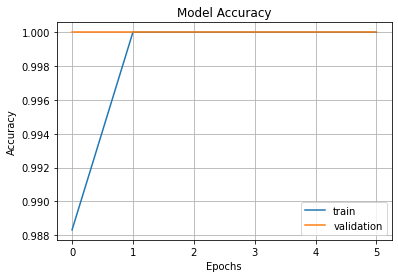

In [8]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:
"""
# ks score
from sklearn.metrics import roc_auc_score,roc_curve
y_pre=model.predict_proba(X_test)
y_0=list(y_pre[:,1])

fpr,tpr,thresholds=roc_curve(y_test,y_0)  #计算fpr,tpr,thresholds
auc=roc_auc_score(y_test,y_0)

KS_max=0
best_thr=0
for i in range(len(fpr)):
    if(i==0):
        KS_max=tpr[i]-fpr[i]
        best_thr=thresholds[i]
    elif (tpr[i]-fpr[i]>KS_max):
        KS_max = tpr[i] - fpr[i]
        best_thr = thresholds[i]
"""



In [20]:
#model.load_weights('./model/')
model = tf.keras.models.load_model('./model/my_model.h5')

pred = model.evaluate_generator(val_ds, verbose=1)

/Users/doradong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


19/19 [==============================] - 36s 2s/step - loss: 3.2594e-23 - accuracy: 1.0000


In [25]:
print('The loss is {}\nThe accuracy of validation set is {}'.format(pred[0], pred[1]))

The loss is 3.2593978177078996e-23
The accuracy of validation set is 1.0


In [51]:
# inference of single image
import cv2
image=cv2.imread('./data/used/front/A00147')
image_resized= cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)

pred=model.predict(image)
pred = np.int(np.round(pred))
print(model.predict(image),pred)

def transfer_names(val_ds):
    class_names = []
    for name in val_ds.class_names:
        if name=='front':
            class_names.append('criminal')
        else:
            class_names.append('normal')
    return class_names
class_names = transfer_names(val_ds)
output_class=class_names[int(pred)]
print("The predicted class is", output_class)

[[2.0127497e-21]] 0
The predicted class is normal


/Users/doradong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [42]:
# tkinter
